In [40]:
# Clean module imports for ADM1 (no utils)
# Use adm1.solver.simulate as the canonical solver and provide a wrapper for legacy calls

import adm1
from adm1.solver import simulate as simulate_func
from adm1.dae import DAESolve as DAESolve_func  # optional explicit DAE usage


def simulate(t_step, solvermethod):
    """Backward-compatible wrapper using ADM1_ODE and state_zero from this notebook."""
    ode_f = globals().get('ADM1_ODE')
    y0 = globals().get('state_zero')
    if ode_f is None or y0 is None:
        raise ValueError("Please define ADM1_ODE and state_zero before calling simulate().")
    return simulate_func(t_step, solvermethod, y0=y0, ode_func=ode_f)


In [1]:
import numpy as np
import scipy.integrate
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
mixing_ratio=0.99999 # feed1/total

In [3]:
## unit for each parameter is commented after it is declared (inline)
## if the suggested value for the parameter is different -
## The original default value from the original ADM1 report by Batstone et al (2002), is commented after each unit (inline)

##constant definition from the Rosen et al (2006) BSM2 report
R =  0.083145 #bar.M^-1.K^-1
T_base =  298.15 #K
p_atm =  1.013 #bar
T_op =  308.15 #k ##T_ad #=35 C

##parameter definition from the Rosen et al (2006) BSM2 report bmadm1_report
# Stoichiometric parameter


N_xc =  0.0376 / 14
N_I =  0.06 / 14 #kmole N.kg^-1COD
N_aa =  0.007 #kmole N.kg^-1COD

C_xc =  mixing_ratio*0.02786 #kmole C.kg^-1COD
C_sI =  mixing_ratio*0.03 #kmole C.kg^-1COD
C_ch =  mixing_ratio*0.0313 #kmole C.kg^-1COD
C_pr =  mixing_ratio*0.03 #kmole C.kg^-1COD
C_li =  mixing_ratio*0.022 #kmole C.kg^-1COD
C_xI =  mixing_ratio*0.03 #kmole C.kg^-1COD

C_xc_ref = 0.02786 #kmole C.kg^-1COD
C_sI_ref =  0.03 #kmole C.kg^-1COD
C_ch_ref =  0.0313 #kmole C.kg^-1COD
C_pr_ref =  0.03 #kmole C.kg^-1COD
C_li_ref =  0.022 #kmole C.kg^-1COD
C_xI_ref =  0.03 #kmole C.kg^-1COD'


C_su =  0.0313 #kmole C.kg^-1COD
C_aa =  0.03 #kmole C.kg^-1COD
f_fa_li =  0.95
C_fa =  0.0217 #kmole C.kg^-1COD
f_h2_su =  0.19
f_bu_su =  0.13
f_pro_su =  0.27
f_ac_su =  0.41
N_bac =  0.08 / 14 #kmole N.kg^-1COD
C_bu =  0.025 #kmole C.kg^-1COD
C_pro =  0.0268 #kmole C.kg^-1COD
C_ac =  0.0313 #kmole C.kg^-1COD
C_bac =  0.0313 #kmole C.kg^-1COD
Y_su =  0.1
f_h2_aa =  0.06
f_va_aa =  0.23
f_bu_aa =  0.26
f_pro_aa =  0.05
f_ac_aa =  0.40
C_va =  0.024 #kmole C.kg^-1COD
Y_aa =  0.08
Y_fa =  0.06
Y_c4 =  0.06
Y_pro =  0.04
C_ch4 =  0.0156 #kmole C.kg^-1COD
Y_ac =  0.05
Y_h2 =  0.06

In [4]:
# Composition fractions for particulate COD of each substrate

##Feed1

f_sI_xc1 = 0.1 
f_xI_xc1 = 0.2 
f_ch_xc1 = 0.2 
f_pr_xc1 = 0.2
f_li_xc1 = 0.3

##Feed2

f_sI_xc2 = 0.1
f_xI_xc2 = 0.2
f_ch_xc2 = 0.2
f_pr_xc2 = 0.2
f_li_xc2 = 0.3

In [5]:
# Define parameters for both substrates

variation_factor3=1

k_dis1 = 0.55    # Disintegration rate for Substrate 1 (d^-1)
k_dis2 = 0.55    # Disintegration rate for Substrate 2 (d^-1)

variation_factor3=1

# Hydrolysis rates for Substrate 1 (d^-1)
k_hyd_ch1 = 10; k_hyd_pr1 = 10; k_hyd_li1 = 10
#k_hyd_ch1 = 10; k_hyd_pr1 = 10; k_hyd_li1 = 10


# Hydrolysis rates for Substrate 2 (d^-1)

k_hyd_ch2 = 5.22; k_hyd_pr2 = 1.86; k_hyd_li2 = variation_factor3*1.24
#k_hyd_ch2 = 10; k_hyd_pr2 = 10; k_hyd_li2 = 10

In [6]:
# Biochemical parameter values from the Rosen et al (2006) BSM2 report
K_S_IN =  10 ** -4 #M
k_m_su =  30 #d^-1
K_S_su =  0.5 #kgCOD.m^-3
pH_UL_aa =  5.5
pH_LL_aa =  4
k_m_aa =  50 #d^-1
K_S_aa =  0.3 ##kgCOD.m^-3
k_m_fa =  6 #d^-1
K_S_fa =  0.4 #kgCOD.m^-3
K_I_h2_fa =  5 * 10 ** -6 #kgCOD.m^-3
k_m_c4 =  20 #d^-1
K_S_c4 =  0.2 #kgCOD.m^-3
K_I_h2_c4 =  10 ** -5 #kgCOD.m^-3
k_m_pro =  13 #d^-1
K_S_pro =  0.1 #kgCOD.m^-3
K_I_h2_pro =  3.5 * 10 ** -6 #kgCOD.m^-3
k_m_ac =  8 #kgCOD.m^-3
K_S_ac =  0.15 #kgCOD.m^-3
K_I_nh3 =  0.0018 #M
pH_UL_ac =  7
pH_LL_ac =  6
k_m_h2 =  35 #d^-1
K_S_h2 =  7 * 10 ** -6 #kgCOD.m^-3
pH_UL_h2 =  6
pH_LL_h2 =  5
k_dec_X_su =  0.02 #d^-1
k_dec_X_aa =  0.02 #d^-1
k_dec_X_fa =  0.02 #d^-1
k_dec_X_c4 =  0.02 #d^-1
k_dec_X_pro =  0.02 #d^-1
k_dec_X_ac =  0.02 #d^-1
k_dec_X_h2 =  0.02 #d^-1
## M is kmole m^-3

In [7]:
# Physico-chemical parameter values from the Rosen et al (2006) BSM2 report
T_ad =  308.15 #K


K_w =  10 ** -14.0 * np.exp((55900 / (100 * R)) * (1 / T_base - 1 / T_ad)) #M #2.08 * 10 ^ -14

K_a_va =  10 ** -4.86 #M  ADM1 value = 1.38 * 10 ^ -5
K_a_bu =  10 ** -4.82 #M #1.5 * 10 ^ -5
K_a_pro =  10 ** -4.88 #M #1.32 * 10 ^ -5
K_a_ac =  10 ** -4.76 #M #1.74 * 10 ^ -5


K_a_co2 =  10 ** -6.35 * np.exp((7646 / (100 * R)) * (1 / T_base - 1 / T_ad)) #M #4.94 * 10 ^ -7
K_a_IN =  10 ** -9.25 * np.exp((51965 / (100 * R)) * (1 / T_base - 1 / T_ad)) #M #1.11 * 10 ^ -9


k_A_B_va =  10 ** 10 #M^-1 * d^-1
k_A_B_bu =  10 ** 10 #M^-1 * d^-1
k_A_B_pro =  10 ** 10 #M^-1 * d^-1
k_A_B_ac =  10 ** 10 #M^-1 * d^-1
k_A_B_co2 =  10 ** 10 #M^-1 * d^-1
k_A_B_IN =  10 ** 10 #M^-1 * d^-1


p_gas_h2o =  0.0313 * np.exp(5290 * (1 / T_base - 1 / T_ad)) #bar #0.0557
k_p = 5 * 10 ** 4 #m^3.d^-1.bar^-1 #only for BSM2 AD conditions, recalibrate for other AD cases #gas outlet friction
k_L_a =  200.0 #d^-1
K_H_co2 =  0.035 * np.exp((-19410 / (100 * R))* (1 / T_base - 1 / T_ad)) #Mliq.bar^-1 #0.0271
K_H_ch4 =  0.0014 * np.exp((-14240 / (100 * R)) * (1 / T_base - 1 / T_ad)) #Mliq.bar^-1 #0.00116
K_H_h2 =  7.8 * 10 ** -4 * np.exp(-4180 / (100 * R) * (1 / T_base - 1 / T_ad)) #Mliq.bar^-1 #7.38*10^-4

In [8]:
##variable definition
# Steady-state input values (influent/feed) for BSM2 ADM1 from the Rosen et al (2006) BSM2 report


S_su_in = 0.001 #kg COD.m^-3
S_aa_in = 0.001 #kg COD.m^-3
S_fa_in = 0.001 #kg COD.m^-3
S_va_in = 0.001 #kg COD.m^-3
S_bu_in = 0.001 #kg COD.m^-3
S_pro_in = 0.001 #kg COD.m^-3
S_ac_in = 0.001 #kg COD.m^-3
S_h2_in = 10 ** -8  #kg COD.m^-3
S_ch4_in = 10 ** -5  #kg COD.m^-3
S_IC_in = 0.04 #kmole C.m^-3
S_IN_in = 0.01 #kmole N.m^-3
S_I_in = 0.02 #kg COD.m^-3



#______________Feed1 input_____________________

X_xc1_in = mixing_ratio*0 #kg COD.m^-3
X_ch1_in = mixing_ratio*20.057 #kg COD.m^-3
X_pr1_in = mixing_ratio*12.674 #kg COD.m^-3
X_li1_in = mixing_ratio*9.997 #kg COD.m^-3

#______________Feed2 input_____________________

variation_factor4=1


X_xc2_total=variation_factor4*259.992
X_ch2_fraction=0.79
X_pr2_fraction=0.184
X_li2_fraction=0.026



X_xc2_in = (1-mixing_ratio)*0 #kg COD.m^-3
X_ch2_in = (1-mixing_ratio)*X_ch2_fraction*X_xc2_total      #205.31 #kg COD.m^-3
X_pr2_in = (1-mixing_ratio)*X_pr2_fraction*X_xc2_total  #kg COD.m^-3
X_li2_in = (1-mixing_ratio)*X_li2_fraction*X_xc2_total  #kg COD.m^-3

#__________________________________________

X_su_in = 0.0 #kg COD.m^-3
X_aa_in = 0.0 #kg COD.m^-3
X_fa_in = 0.0 #kg COD.m^-3
X_c4_in = 0.0 #kg COD.m^-3
X_pro_in = 0.0 #kg COD.m^-3
X_ac_in = 0.0 #kg COD.m^-3
X_h2_in = 0.0 #kg COD.m^-3
X_I_in = 25.0 #kg COD.m^-3

S_cation_in = 0.04 #kmole.m^-3
S_anion_in = 0.02 #kmole.m^-3

In [9]:
# SciPy ADM1 input array from Pettigrew (2017) jADM1 and Rosen et al (2006) BSM2 report
# initiate variables (initial values for the reactor state at t0)


S_su = 0.00001 #kg COD.m^-3
S_aa = 0.00001 #kg COD.m^-3
S_fa = 0.00001 #kg COD.m^-3
S_va = 0.00001 #kg COD.m^-3
S_bu = 0.00001 #kg COD.m^-3
S_pro = 0.00001 #kg COD.m^-3
S_ac = 0.00001 #kg COD.m^-3
S_h2 =  10 ** -8
S_ch4 = 10** -5 #kg COD.m^-3
S_IC = 0.04 #kg COD.m^-3
S_IN = 0.01 #kmole C.m^-3
S_I = 0.02 #kmole N.m^-3

#______________Feed1 initial_____________________

X_xc1 = mixing_ratio*(2/(2+5+20+5))*0.00001 #kg COD.m^-3
X_ch1 = mixing_ratio*(5/(2+5+20+5))*0.00001 #COD.m^-3
X_pr1 = mixing_ratio*(20/(2+5+20+5))*0.00001 #kg COD.m^-3
X_li1 = mixing_ratio*(5/(2+5+20+5))*0.00001 #kg COD.m^-3

#______________Feed2 initial_____________________

X_xc2 = (1-mixing_ratio)*(0/(205+47.76+6.925))*0.00001 #kg COD.m^-3
X_ch2 = (1-mixing_ratio)*(205/(205+47.76+6.925))*0.00001 #kg COD.m^-3
X_pr2 = (1-mixing_ratio)*(47.76/(205+47.76+6.925))*0.00001 #kg COD.m^-3
X_li2 = (1-mixing_ratio)*(6.925/(205+47.76+6.925))*0.00001 #kg COD.m^-3
#_________________________________________

variation_factor=50


X_su = 1.41 #kg COD.m^-3
X_aa = 0.75 #kg COD.m^-3
X_fa = 0.38 #kg COD.m^-3
X_c4 = 0.35 #kg COD.m^-3
X_pro = variation_factor*0.197 #kg COD.m^-3
X_ac = variation_factor*0.95 #kg COD.m^-3
X_h2 = 0.466 #kg COD.m^-3
X_I = 25.6 #kg COD.m^-3


#________________________________________



S_cation = 0.04000 #kmole.m^-3
S_anion = 0.02 #kmole.m^-3


pH = 7.4655377
S_H_ion = 6.04e-8 #kmole H.m^-3
S_va_ion = 0.0082  #kg COD.m^-3
S_bu_ion = 0.0156 #kg COD.m^-3
S_pro_ion = 0.0172 #kg COD.m^-3
S_ac_ion = 0.11199 #kg COD.m^-3
S_hco3_ion = 0.15415 #kmole C.m^-3
S_nh3 = 0.0025 #kmole N.m^-3
#S_nh4_ion = 0.126138 #kmole N.m^-3 the initial value is from Rosen et al (2006) BSM2 report and it is calculated further down and does not need to be initiated
#S_co2 = 0.0093003 #kmole C.m^-3 the initial value is from Rosen et al (2006) BSM2 report and it is calculated further down and does not need to be initiated
S_gas_h2 = 4.91 * 10 ** -6 #kg COD.m^-3
S_gas_ch4 = 1.78 #kg COD.m^-3
S_gas_co2 = 0.025 #kmole C.m^-3



In [10]:
# related to pH inhibition taken from BSM2 report, they are global variables to avoid repeating them in DAE part
K_pH_aa =  (10 ** (-1 * (pH_LL_aa + pH_UL_aa) / 2.0))
nn_aa =  (3.0 / (pH_UL_aa - pH_LL_aa)) #we need a differece between N_aa and n_aa to avoid typos and nn_aa refers to n_aa in BSM2 report
K_pH_ac =  (10 ** (-1 * (pH_LL_ac + pH_UL_ac) / 2.0))
n_ac =  (3.0 / (pH_UL_ac - pH_LL_ac))
K_pH_h2 =  (10 ** (-1 * (pH_LL_h2 + pH_UL_h2) / 2.0))
n_h2 =  (3.0 / (pH_UL_h2 - pH_LL_h2))

S_nh4_ion =  (S_IN - S_nh3)

S_co2 =  (S_IC - S_hco3_ion)

#pH equation

In [11]:
# related to pH inhibition taken from BSM2 report, they are global variables to avoid repeating them in DAE part
K_pH_aa =  (10 ** (-1 * (pH_LL_aa + pH_UL_aa) / 2.0))
nn_aa =  (3.0 / (pH_UL_aa - pH_LL_aa)) #we need a differece between N_aa and n_aa to avoid typos and nn_aa refers to the n_aa in BSM2 report
K_pH_ac = (10 ** (-1 * (pH_LL_ac + pH_UL_ac) / 2.0))
n_ac =  (3.0 / (pH_UL_ac - pH_LL_ac))
K_pH_h2 =  (10 ** (-1 * (pH_LL_h2 + pH_UL_h2) / 2.0))
n_h2 =  (3.0 / (pH_UL_h2 - pH_LL_h2))

#pH equation
#pH = - np.log10(S_H_ion)
pH = 7.4655377 # initial pH

In [12]:
q_ad =  500
#q_ad =  1000

q_ad1 =  mixing_ratio*q_ad #m^3.d^-1 initial flow rate (can be modified during the simulation by the control algorithm)
q_ad2= q_ad-q_ad1


density=1000  #kg/m3

VS=0.1 #kg/kg
VS_in=density*q_ad*VS*0.001   #tonne

print(q_ad1, q_ad2, VS_in)

499.995 0.0049999999999954525 50.0


In [13]:
# Physical parameter values

# Physical parameter values used in BSM2 from the Rosen et al (2006) BSM2 report
HRT=20  #days

V_liq =HRT*q_ad   #m^3
V_gas =  0.088*V_liq #m^3
#V_liq =  10000 #m^3
#V_gas =  1000 #m^3
V_ad = V_liq + V_gas #m^-3


print(V_liq)
print(V_gas)

10000
880.0


In [14]:
state_zero = [S_su,
              S_aa,
              S_fa,
              S_va,
              S_bu,
              S_pro,
              S_ac,
              S_h2,
              S_ch4,
              S_IC,
              S_IN,
              S_I,
              X_xc1,
              X_ch1,
              X_pr1,
              X_li1,
              X_xc2,
              X_ch2,
              X_pr2,
              X_li2,
              X_su,
              X_aa,
              X_fa,
              X_c4,
              X_pro,
              X_ac,
              X_h2,
              X_I,
              S_cation,
              S_anion,
              S_H_ion,
              S_va_ion,
              S_bu_ion,
              S_pro_ion,
              S_ac_ion,
              S_hco3_ion,
              S_co2,
              S_nh3,
              S_nh4_ion,
              S_gas_h2,
              S_gas_ch4,
              S_gas_co2]

state_input = [S_su_in,
              S_aa_in,
              S_fa_in,
              S_va_in,
              S_bu_in,
              S_pro_in,
              S_ac_in,
              S_h2_in,
              S_ch4_in,
              S_IC_in,
              S_IN_in,
              S_I_in,
              X_xc1_in,
              X_ch1_in,
              X_pr1_in,
              X_li1_in,
              X_xc2_in,
              X_ch2_in,
              X_pr2_in,
              X_li2_in,
              X_su_in,
              X_aa_in,
              X_fa_in,
              X_c4_in,
              X_pro_in,
              X_ac_in,
              X_h2_in,
              X_I_in,
              S_cation_in,
              S_anion_in]

In [15]:
# Define the labels for each state variable
state_labels = [
    "S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4",
    "S_IC", "S_IN", "S_I", "X_xc1", "X_ch1", "X_pr1", "X_li1", "X_xc2", "X_ch2", 
    "X_pr2", "X_li2", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", 
    "X_I", "S_cation", "S_anion", "S_H_ion", "S_va_ion", "S_bu_ion", "S_pro_ion", 
    "S_ac_ion", "S_hco3_ion", "S_co2", "S_nh3", "S_nh4_ion", "S_gas_h2", 
    "S_gas_ch4", "S_gas_co2"
]

input_labels = [
    "S_su_in", "S_aa_in", "S_fa_in", "S_va_in", "S_bu_in", "S_pro_in", "S_ac_in", 
    "S_h2_in", "S_ch4_in", "S_IC_in", "S_IN_in", "S_I_in", "X_xc1_in", "X_ch1_in", 
    "X_pr1_in", "X_li1_in", "X_xc2_in", "X_ch2_in", "X_pr2_in", "X_li2_in", "X_su_in", 
    "X_aa_in", "X_fa_in", "X_c4_in", "X_pro_in", "X_ac_in", "X_h2_in", "X_I_in", 
    "S_cation_in", "S_anion_in"
]

# Printing state_zero
print("State Zero Values:")
for label, value in zip(state_labels, state_zero):
    print(f"{label}: {value}")

print("\nState Input Values:")
for label, value in zip(input_labels, state_input):
    print(f"{label}: {value}")

State Zero Values:
S_su: 1e-05
S_aa: 1e-05
S_fa: 1e-05
S_va: 1e-05
S_bu: 1e-05
S_pro: 1e-05
S_ac: 1e-05
S_h2: 1e-08
S_ch4: 1e-05
S_IC: 0.04
S_IN: 0.01
S_I: 0.02
X_xc1: 6.2499375e-07
X_ch1: 1.5624843750000003e-06
X_pr1: 6.249937500000001e-06
X_li1: 1.5624843750000003e-06
X_xc2: 0.0
X_ch2: 7.894179486649867e-11
X_pr2: 1.8391512794263297e-11
X_li2: 2.6666923387829425e-12
X_su: 1.41
X_aa: 0.75
X_fa: 0.38
X_c4: 0.35
X_pro: 9.85
X_ac: 47.5
X_h2: 0.466
X_I: 25.6
S_cation: 0.04
S_anion: 0.02
S_H_ion: 6.04e-08
S_va_ion: 0.0082
S_bu_ion: 0.0156
S_pro_ion: 0.0172
S_ac_ion: 0.11199
S_hco3_ion: 0.15415
S_co2: -0.11415
S_nh3: 0.0025
S_nh4_ion: 0.0075
S_gas_h2: 4.91e-06
S_gas_ch4: 1.78
S_gas_co2: 0.025

State Input Values:
S_su_in: 0.001
S_aa_in: 0.001
S_fa_in: 0.001
S_va_in: 0.001
S_bu_in: 0.001
S_pro_in: 0.001
S_ac_in: 0.001
S_h2_in: 1e-08
S_ch4_in: 1e-05
S_IC_in: 0.04
S_IN_in: 0.01
S_I_in: 0.02
X_xc1_in: 0.0
X_ch1_in: 20.056799429999998
X_pr1_in: 12.67387326
X_li1_in: 9.99690003
X_xc2_in: 0.0
X_ch

In [19]:
##time definition
days = 150
timeSteps = days*24 #every 15 minutes 
t = np.linspace(0, days, timeSteps) #sequence of timesteps as fractions of days

In [20]:
# Initiate the cache data frame for storing simulation results
simulate_results = pd.DataFrame([state_zero])
columns = ["S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4", "S_IC", "S_IN", "S_I", "X_xc1", "X_ch1", "X_pr1", "X_li1", "X_xc2", "X_ch2", "X_pr2", "X_li2", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", "X_I", "S_cation", "S_anion", "pH", "S_va_ion", "S_bu_ion", "S_pro_ion", "S_ac_ion", "S_hco3_ion", "S_co2", "S_nh3", "S_nh4_ion", "S_gas_h2", "S_gas_ch4", "S_gas_co2"]
simulate_results.columns = columns

In [21]:
#switch between ODE (0) and DAE (1) implementations
DAE_switch = 1

t0=0
n=0

In [22]:

# Initiate the cache data frame for storing simulation results
simulate_results = pd.DataFrame([state_zero])
columns = ["S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4", "S_IC", "S_IN", "S_I", "X_xc1", "X_ch1", "X_pr1", "X_li1", "X_xc2", "X_ch2", "X_pr2", "X_li2", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", "X_I", "S_cation", "S_anion", "pH", "S_va_ion", "S_bu_ion", "S_pro_ion", "S_ac_ion", "S_hco3_ion", "S_co2", "S_nh3", "S_nh4_ion", "S_gas_h2", "S_gas_ch4", "S_gas_co2"]
simulate_results.columns = columns

In [23]:
# Initiate cache data frame for storing gasflow values
initflow = {'p_gas_h2': [0],'p_gas_ch4': [0],'p_gas_co2': [0],'p_gas': [0],'q_gas': [0], 'q_ch4': [0], 'total_ch4': [0],'p_gas_ch4/p_gas': [0],'p_gas_co2/p_gas': [0], 'ch4_yield':[0], 'co2_yield':[0] }
gasflow = pd.DataFrame(initflow)
total_ch4 = 0

In [24]:
# Initiate cache data frame for storing inhibition values
initflow = {'I_5': [0],'I_7': [0],'I_8': [0],'I_10': [0],'I_12': [0],'I_pH_aa': [0],'I_pH_h2': [0],'I_IN_lim': [0],'I_h2_fa': [0],'I_h2_c4': [0], 'I_h2_pro': [0]}
inhibition = pd.DataFrame(initflow)

In [25]:
# Initiate cache data frame for storing ions values
initflow = {'S_cation': [0],'S_anion': [0],'S_H_ion': [0],'S_va_ion': [0],'S_bu_ion': [0],'S_pro_ion': [0],'S_ac_ion': [0],'S_hco3_ion': [0],'S_nh4_ion': [0]}
ions = pd.DataFrame(initflow)

In [26]:
if DAE_switch == 0:
  solvermethod = 'Radau'
  tstep = t
  
  # solve ODE for next step 
  sim_S_su, sim_S_aa, sim_S_fa, sim_S_va, sim_S_bu, sim_S_pro, sim_S_ac, sim_S_h2, sim_S_ch4, sim_S_IC, sim_S_IN, sim_S_I,  sim_X_xc1, sim_X_ch1, sim_X_pr1, sim_X_li1, sim_X_xc2, sim_X_ch2, sim_X_pr2, sim_X_li2, sim_X_su, sim_X_aa, sim_X_fa, sim_X_c4, sim_X_pro, sim_X_ac, sim_X_h2, sim_X_I, sim_S_cation, sim_S_anion, sim_S_H_ion, sim_S_va_ion, sim_S_bu_ion, sim_S_pro_ion, sim_S_ac_ion, sim_S_hco3_ion, sim_S_co2, sim_S_nh3, sim_S_nh4_ion, sim_S_gas_h2, sim_S_gas_ch4, sim_S_gas_co2 = simulate(tstep, solvermethod)
  
    
  #store ODE simulation result states
  S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2 = \
  sim_S_su[-1], sim_S_aa[-1], sim_S_fa[-1], sim_S_va[-1], sim_S_bu[-1], sim_S_pro[-1], sim_S_ac[-1], sim_S_h2[-1], sim_S_ch4[-1], sim_S_IC[-1], sim_S_IN[-1], sim_S_I[-1], sim_X_xc1[-1], sim_X_ch1[-1], sim_X_pr1[-1], sim_X_li1[-1], sim_X_xc2[-1], sim_X_ch2[-1], sim_X_pr2[-1], sim_X_li2[-1], sim_X_su[-1], sim_X_aa[-1], sim_X_fa[-1], sim_X_c4[-1], sim_X_pro[-1], sim_X_ac[-1], sim_X_h2[-1], sim_X_I[-1], sim_S_cation[-1], sim_S_anion[-1], sim_S_H_ion[-1], sim_S_va_ion[-1], sim_S_bu_ion[-1], sim_S_pro_ion[-1], sim_S_ac_ion[-1], sim_S_hco3_ion[-1], sim_S_co2[-1], sim_S_nh3[-1], sim_S_nh4_ion[-1], sim_S_gas_h2[-1], sim_S_gas_ch4[-1], sim_S_gas_co2[-1]
else:
    
  solvermethod = 'DOP853'
#  solvermethod = 'BDF'
  
  for u in t[1:]:
#  for u in range(days):
    n+=1
    
    state_input = [S_su_in,S_aa_in,S_fa_in,S_va_in,S_bu_in,S_pro_in,S_ac_in,S_h2_in,S_ch4_in,S_IC_in,S_IN_in,S_I_in,X_xc1_in,X_ch1_in,X_pr1_in,X_li1_in,X_xc2_in,X_ch2_in,X_pr2_in,X_li2_in,X_su_in,X_aa_in,X_fa_in,X_c4_in,X_pro_in,X_ac_in,X_h2_in,X_I_in,S_cation_in,S_anion_in]
    
    # Span for next time step
    tstep = [t0,u]
  
    # solve ODE for next step 
    sim_S_su, sim_S_aa, sim_S_fa, sim_S_va, sim_S_bu, sim_S_pro, sim_S_ac, sim_S_h2, sim_S_ch4, sim_S_IC, sim_S_IN, sim_S_I,  sim_X_xc1, sim_X_ch1, sim_X_pr1, sim_X_li1, sim_X_xc2, sim_X_ch2, sim_X_pr2, sim_X_li2, sim_X_su, sim_X_aa, sim_X_fa, sim_X_c4, sim_X_pro, sim_X_ac, sim_X_h2, sim_X_I, sim_S_cation, sim_S_anion, sim_S_H_ion, sim_S_va_ion, sim_S_bu_ion, sim_S_pro_ion, sim_S_ac_ion, sim_S_hco3_ion, sim_S_co2, sim_S_nh3, sim_S_nh4_ion, sim_S_gas_h2, sim_S_gas_ch4, sim_S_gas_co2 = simulate(tstep, solvermethod)
  
    #store ODE simulation result states
    S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2 = \
    sim_S_su[-1], sim_S_aa[-1], sim_S_fa[-1], sim_S_va[-1], sim_S_bu[-1], sim_S_pro[-1], sim_S_ac[-1], sim_S_h2[-1], sim_S_ch4[-1], sim_S_IC[-1], sim_S_IN[-1], sim_S_I[-1], sim_X_xc1[-1], sim_X_ch1[-1], sim_X_pr1[-1], sim_X_li1[-1],sim_X_xc2[-1], sim_X_ch2[-1], sim_X_pr2[-1], sim_X_li2[-1], sim_X_su[-1], sim_X_aa[-1], sim_X_fa[-1], sim_X_c4[-1], sim_X_pro[-1], sim_X_ac[-1], sim_X_h2[-1], sim_X_I[-1], sim_S_cation[-1], sim_S_anion[-1], sim_S_H_ion[-1], sim_S_va_ion[-1], sim_S_bu_ion[-1], sim_S_pro_ion[-1], sim_S_ac_ion[-1], sim_S_hco3_ion[-1], sim_S_co2[-1], sim_S_nh3[-1], sim_S_nh4_ion[-1], sim_S_gas_h2[-1], sim_S_gas_ch4[-1], sim_S_gas_co2[-1]
    
    DAESolve()
    ##############

    prevS_H_ion = S_H_ion

    
    #I_pH_aa =  ((K_pH_aa ** nn_aa) / (S_H_ion ** nn_aa + K_pH_aa ** nn_aa))
    #I_pH_ac =  ((K_pH_ac ** n_ac) / (S_H_ion ** n_ac + K_pH_ac ** n_ac))
    #I_pH_h2 =  ((K_pH_h2 ** n_h2) / (S_H_ion ** n_h2 + K_pH_h2 ** n_h2))
    #I_IN_lim =  (1 / (1 + (K_S_IN / S_IN)))
    #I_h2_fa =  (1 / (1 + (S_h2 / K_I_h2_fa)))
    #I_h2_c4 =  (1 / (1 + (S_h2 / K_I_h2_c4)))
    #I_h2_pro =  (1 / (1 + (S_h2 / K_I_h2_pro)))
    #I_nh3 =  (1 / (1 + (S_nh3 / K_I_nh3)))

    
    I_pH_aa = 1
    I_pH_ac = 1
    I_pH_h2 = 1
    I_IN_lim = 1
    I_h2_fa = 1
    I_h2_c4 = 1
    I_h2_pro = 1
    I_nh3 = 1


    I_5 = I_pH_aa * I_IN_lim
    I_6 = I_5
    I_7 = I_pH_aa * I_IN_lim * I_h2_fa
    I_8 = I_pH_aa * I_IN_lim * I_h2_c4
    I_9 = I_8
    I_10 = I_pH_aa * I_IN_lim * I_h2_pro
    I_12 = I_pH_h2 * I_IN_lim
    
    
    

    inhibittemp = {'I_5': I_5,'I_7': I_7,'I_8': I_8,'I_10': I_10,'I_12': I_12, 'I_pH_aa': I_pH_aa,'I_pH_ac': I_pH_ac,'I_pH_h2': I_pH_h2, 'I_IN_lim': I_IN_lim,'I_h2_fa': I_h2_fa,'I_h2_c4': I_h2_c4,'I_h2_pro': I_h2_pro,'I_nh3': I_nh3}
    inhibition = pd.concat([inhibition, pd.DataFrame([inhibittemp])], ignore_index=True)

    ################

    S_nh4_ion =  (S_IN - S_nh3)
    S_co2 =  (S_IC - S_hco3_ion)
    #pH = - np.log10(S_H_ion)

    # Algebraic equations 
    

    
    
    p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
    p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
    p_gas_co2 =  (S_gas_co2 * R * T_op)
    
    Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
    Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
    Rho_T_10 =  (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    
    p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o)
    q_gas =  (k_p * (p_gas- p_atm))
    
    #q_gas= (R*T_op/(p_atm-p_gas_h2o))*V_liq*(Rho_T_8/16+Rho_T_9/64+Rho_T_10)
    
    if q_gas < 0:    
     q_gas = 0
    
    q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
    q_co2 = q_gas * (p_gas_co2/p_gas) # co2 flow
    q_h2 = q_gas * (p_gas_h2/p_gas) # h2 flow

    if q_ch4 < 0:
     q_ch4 = 0

    total_ch4 = total_ch4 + q_ch4 

    flowtemp = {'p_gas_h2': p_gas_h2,'p_gas_ch4': p_gas_ch4,'p_gas_co2': p_gas_co2,'p_gas': p_gas,'q_gas': q_gas, 'q_ch4': q_ch4, 'total_ch4': total_ch4, 'p_gas_ch4/p_gas': p_gas_ch4/p_gas,'p_gas_co2/p_gas': p_gas_co2/p_gas, 'ch4_yield':q_ch4/VS_in, 'co2_yield':q_co2/VS_in, 'h2_yield':q_h2/VS_in}
    gasflow = pd.concat([gasflow, pd.DataFrame([flowtemp])], ignore_index=True)

    total_ch4 = total_ch4 + q_ch4     
    
    ############
       
    ionstemp = {'S_cation': S_cation,'S_anion': S_anion,'S_H_ion': S_H_ion,'S_va_ion': S_va_ion,'S_bu_ion': S_bu_ion,'S_pro_ion': S_pro_ion,'S_ac_ion': S_ac_ion,'S_hco3_ion': S_hco3_ion,'S_nh4_ion': S_nh4_ion}
    ions = pd.concat([ions, pd.DataFrame([ionstemp])], ignore_index=True)

    
    
    ##############

    state_zero = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, X_xc1, X_ch1, X_pr1, X_li1, X_xc2, X_ch2, X_pr2, X_li2, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_co2, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2]
    
    dfstate_zero = pd.DataFrame([state_zero], columns = columns)
    simulate_results = pd.concat([simulate_results, dfstate_zero], ignore_index=True)
    t0 = u  

In [27]:
p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
p_gas_co2 =  (S_gas_co2 * R * T_op)
Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
Rho_T_10 =  (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    
p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o)
q_gas =  (k_p * (p_gas- p_atm))

#q_gas= (R*T_op/(p_atm-p_gas_h2o))*V_liq*(Rho_T_8/16+Rho_T_9/64+Rho_T_10)

if q_gas < 0:    
  q_gas = 0

q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
if q_ch4 < 0:
  q_ch4 = 0

In [28]:
phlogarray = -1 * np.log10(simulate_results['pH'])
simulate_results['pH'] = phlogarray

In [29]:

print('DAE_switch =', DAE_switch)

print ('S_su =', S_su, "\n",
         'S_aa =', S_aa, "\n",
         'S_fa =', S_fa, "\n",
         'S_va =', S_va, "\n",
         'S_bu =', S_bu, "\n",
         'S_pro =', S_pro, "\n",
         'S_ac =', S_ac, "\n",
         'S_h2 =', S_h2, "\n",
         'S_ch4 =', S_ch4, "\n",
         'S_IC =', S_IC, "\n",
         'S_IN =', S_IN, "\n",
         'S_I =', S_I, "\n",
         'X_xc1 =', X_xc1, "\n",
         'X_ch1 =', X_ch1, "\n",
         'X_pr1 =', X_pr1, "\n",
         'X_li1 =', X_li1, "\n",
         'X_xc2 =', X_xc2, "\n",
         'X_ch2 =', X_ch2, "\n",
         'X_pr2 =', X_pr2, "\n",
         'X_li2 =', X_li2, "\n",
         'X_su =', X_su, "\n",
         'X_aa =', X_aa, "\n",
         'X_fa =', X_fa, "\n",
         'X_c4 =', X_c4, "\n",
         'X_pro =', X_pro, "\n",
         'X_ac =', X_ac, "\n",
         'X_h2 =', X_h2, "\n",
         'X_I =', X_I, "\n",
         'S_cation =', S_cation,"\n", 
         'S_anion =', S_anion, "\n",
         'S_H_ion =', S_H_ion, "\n",
         'S_va_ion =', S_va_ion, "\n",
         'S_bu_ion =', S_bu_ion, "\n",
         'S_pro_ion =', S_pro_ion, "\n",
         'S_ac_ion =', S_ac_ion, "\n",
         'S_hco3_ion =', S_hco3_ion, "\n",
         'S_co2 =', S_co2, "\n",
         'S_nh3 =', S_nh3, "\n",
         'S_nh4_ion =', S_nh4_ion,"\n", 
         'S_gas_h2 =', S_gas_h2, "\n",
         'S_gas_ch4 =', S_gas_ch4, "\n",
         'S_gas_co2 =', S_gas_co2, "\n",

         'p_gas_h2 =', p_gas_h2, "\n",
         'p_gas_ch4 =', p_gas_ch4, "\n",
         'p_gas_co2 =', p_gas_co2, "\n",
         'p_gas =', p_gas,"\n", 
         'q_gas =', q_gas, "\n",
         'q_ch4 =', q_ch4, "\n",
         'biomethane yield =', q_ch4/VS_in, "\n",
         'biomethane yield2 =', q_ch4/V_ad)

DAE_switch = 1
S_su = 0.011944546492604841 
 S_aa = 0.005342934799499444 
 S_fa = 0.09652835401621275 
 S_va = 0.009871965966161135 
 S_bu = 0.014177090219400522 
 S_pro = 0.0155303988708088 
 S_ac = 0.03176406338987771 
 S_h2 = 2.4135261007050667e-07 
 S_ch4 = 0.0600619684838161 
 S_IC = 0.10061227076322368 
 S_IN = 0.06896943113049119 
 S_I = 0.19463279648594795 
 X_xc1 = 0.1560237505815409 
 X_ch1 = 0.1014928002639621 
 X_pr1 = 0.06476182429381283 
 X_li1 = 0.05229741375415207 
 X_xc2 = 1.560253108338917e-06 
 X_ch2 = 1.9519633579901757e-05 
 X_pr2 = 1.2613034040289526e-05 
 X_li2 = 2.819647241767984e-06 
 X_su = 1.4867192613083566 
 X_aa = 0.739992198000725 
 X_fa = 0.42184016859917667 
 X_c4 = 0.3536138713574683 
 X_pro = 0.20099002940215344 
 X_ac = 0.9899492174758804 
 X_h2 = 0.48738874326364334 
 X_I = 25.349597443593964 
 S_cation = 0.04 
 S_anion = 0.02 
 S_H_ion = 7.588937047659854e-08 
 S_va_ion = 0.009817989615490425 
 S_bu_ion = 0.0141063614733367 
 S_pro_ion = 0.01544150

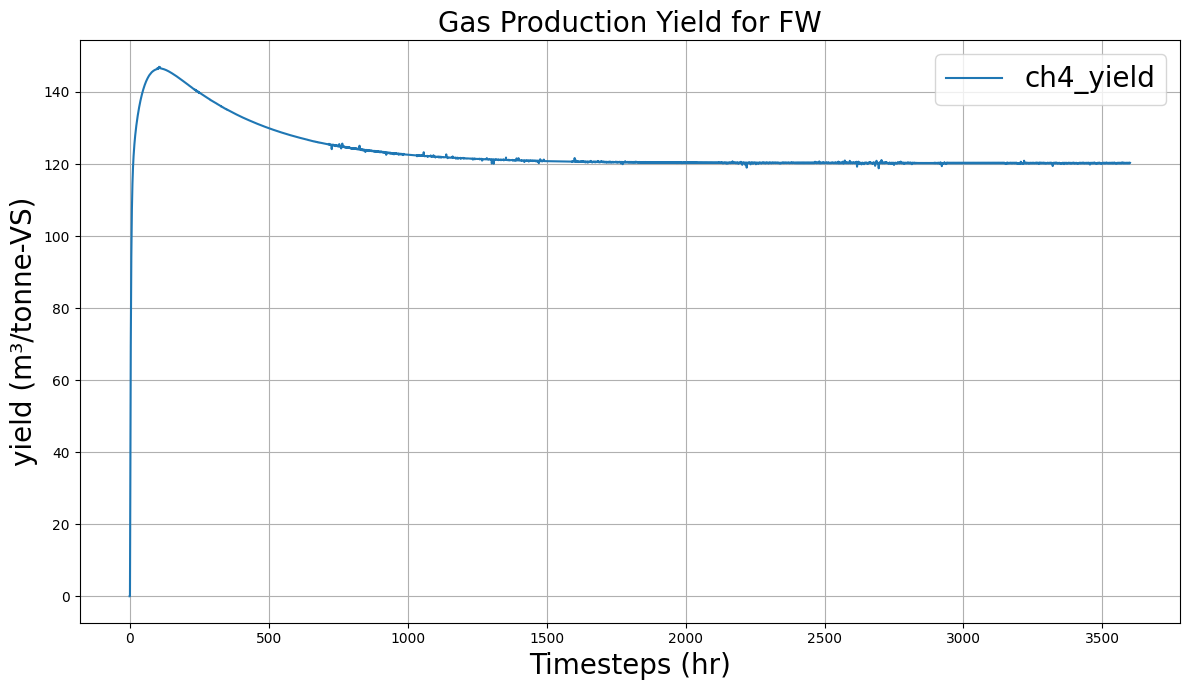

In [30]:
# ─── PLOT GAS FLOWS ──────────────────────────────────────────────────────────────

# If you have a time array t that you looped over, make sure it's in gasflow:
# gasflow['time'] = t   # uncomment or adjust if needed

plt.figure(figsize=(12, 7))

#plt.plot(gasflow['q_gas'],  label='q_gas (Total Gas Flow)')
plt.plot(gasflow['ch4_yield'],  label='ch4_yield')
#plt.plot(gasflow['co2_yield'],  label='co2_yield')
#plt.plot(gasflow['h2_yield'],  label='h2_yield')

plt.xlabel('Timesteps (hr)', fontsize=20)
plt.ylabel('yield (m³/tonne-VS)', fontsize=20)
plt.title('Gas Production Yield for FW', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()
# ──────────────

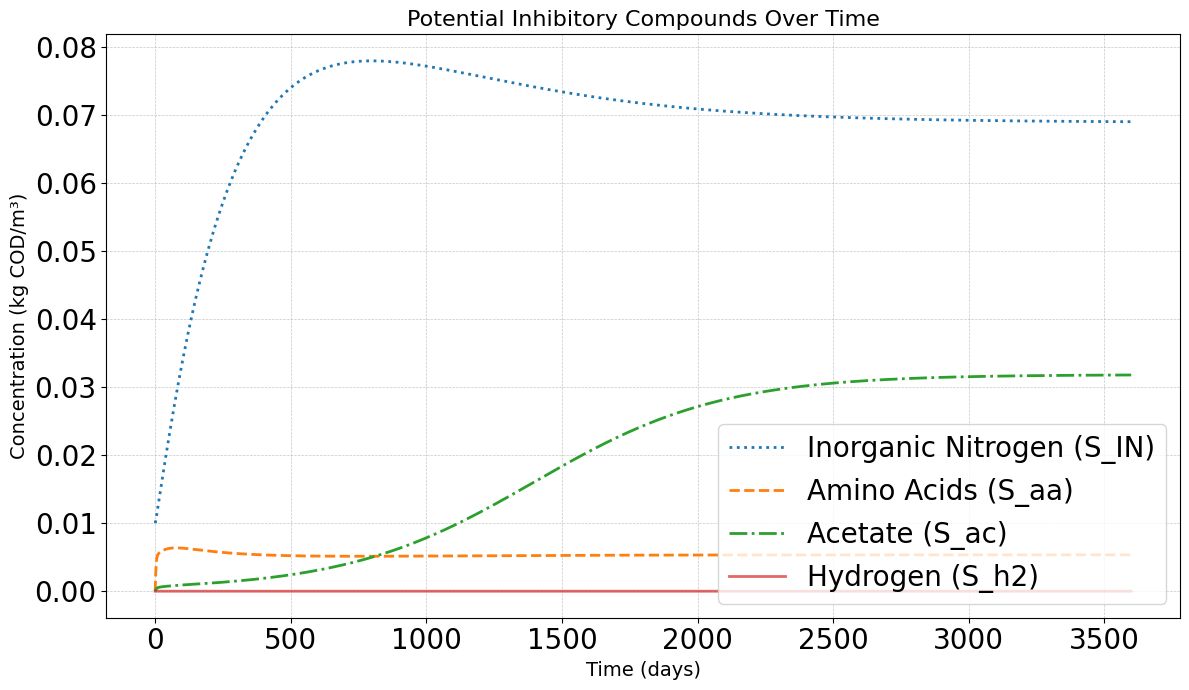

In [31]:
# Plot inhibition indicators with distinctive styles

plt.figure(figsize=(12, 7))

plt.plot(simulate_results['S_IN'], label='Inorganic Nitrogen (S_IN)', linestyle=':', linewidth=2)
plt.plot(simulate_results['S_aa'], label='Amino Acids (S_aa)', linestyle='--', linewidth=2)
plt.plot(simulate_results['S_ac'], label='Acetate (S_ac)', linestyle='-.', linewidth=2)
plt.plot(simulate_results['S_h2'], label='Hydrogen (S_h2)', linestyle='-', linewidth=2, alpha=0.7)

# Title and axis labels
plt.title('Potential Inhibitory Compounds Over Time', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Concentration (kg COD/m³)', fontsize=14)

# Add legend and grid
plt.legend(loc='lower right', fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Enhance layout
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

# Show the plot
plt.show()

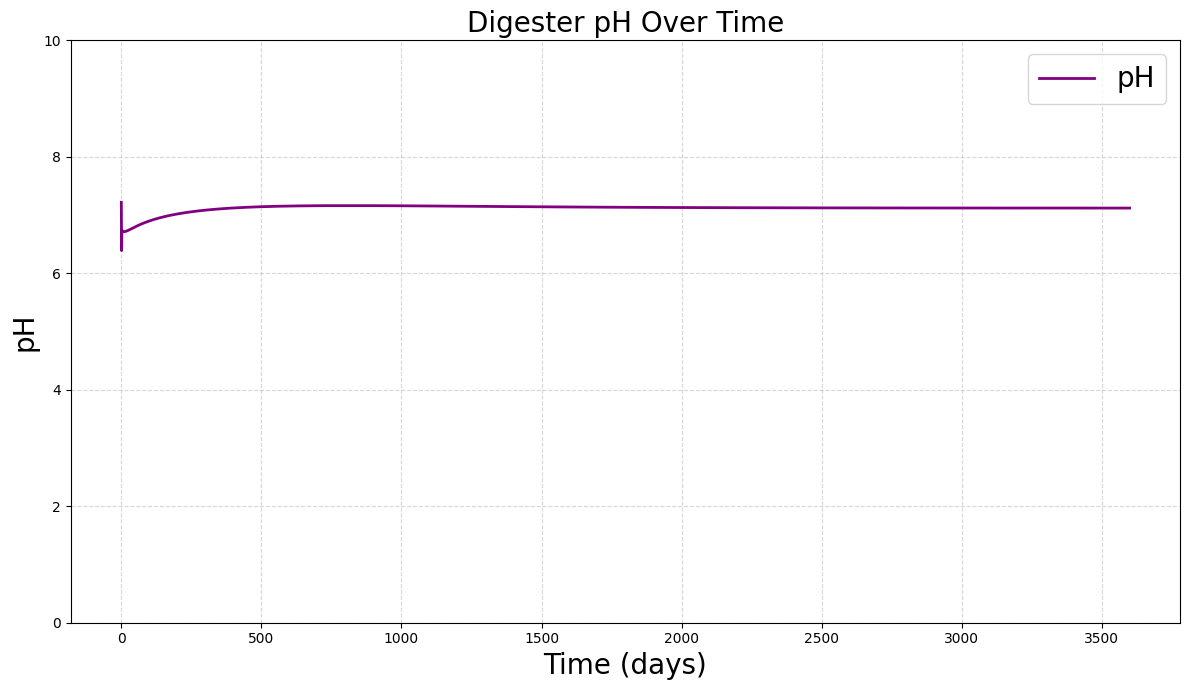

In [32]:
plt.figure(figsize=(12, 7))


plt.plot(simulate_results['pH'], color='purple', linewidth=2, label='pH')


plt.title('Digester pH Over Time', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.ylabel('pH', fontsize=20)
plt.ylim(0, 10)  # typical AD range

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

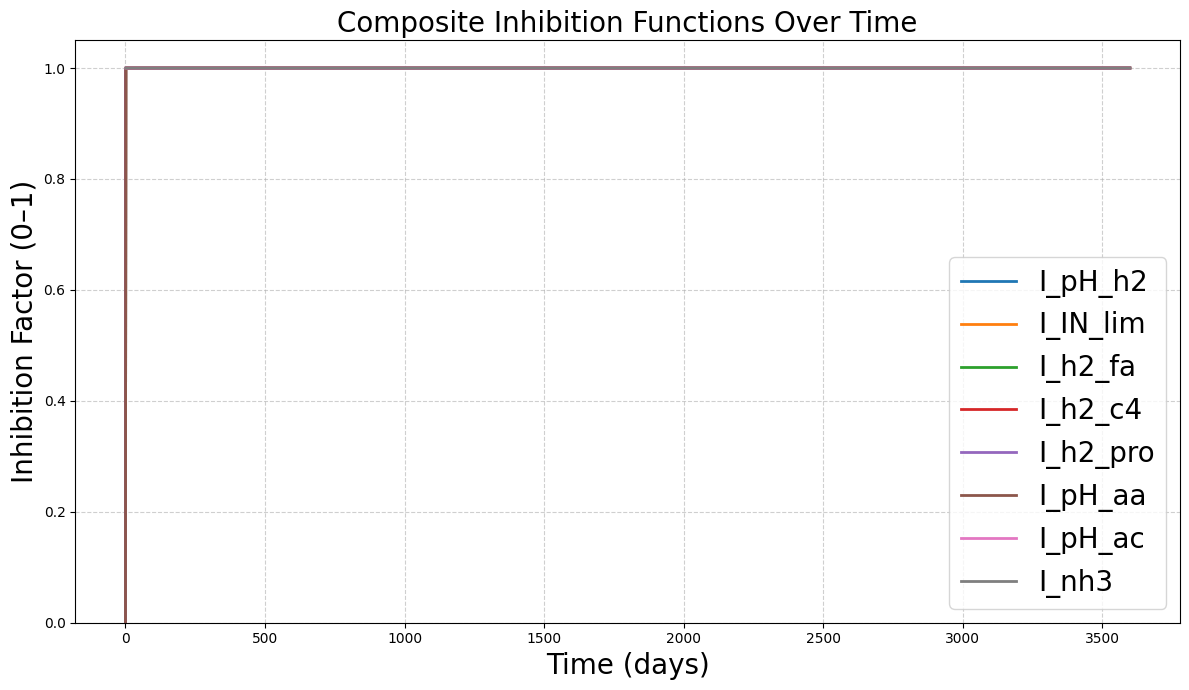

In [33]:
plt.figure(figsize=(12, 7))

plt.plot(inhibition['I_pH_h2'], label='I_pH_h2', linewidth=2)
plt.plot(inhibition['I_IN_lim'], label='I_IN_lim', linewidth=2)
plt.plot(inhibition['I_h2_fa'], label='I_h2_fa', linewidth=2)
plt.plot(inhibition['I_h2_c4'], label='I_h2_c4', linewidth=2)
plt.plot(inhibition['I_h2_pro'], label='I_h2_pro', linewidth=2)

plt.plot(inhibition['I_pH_aa'], label='I_pH_aa', linewidth=2)
plt.plot(inhibition['I_pH_ac'], label='I_pH_ac', linewidth=2)
plt.plot(inhibition['I_nh3'], label='I_nh3', linewidth=2)


plt.title('Composite Inhibition Functions Over Time', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.ylabel('Inhibition Factor (0–1)', fontsize=20)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right',fontsize=20)
plt.tight_layout()
plt.show()


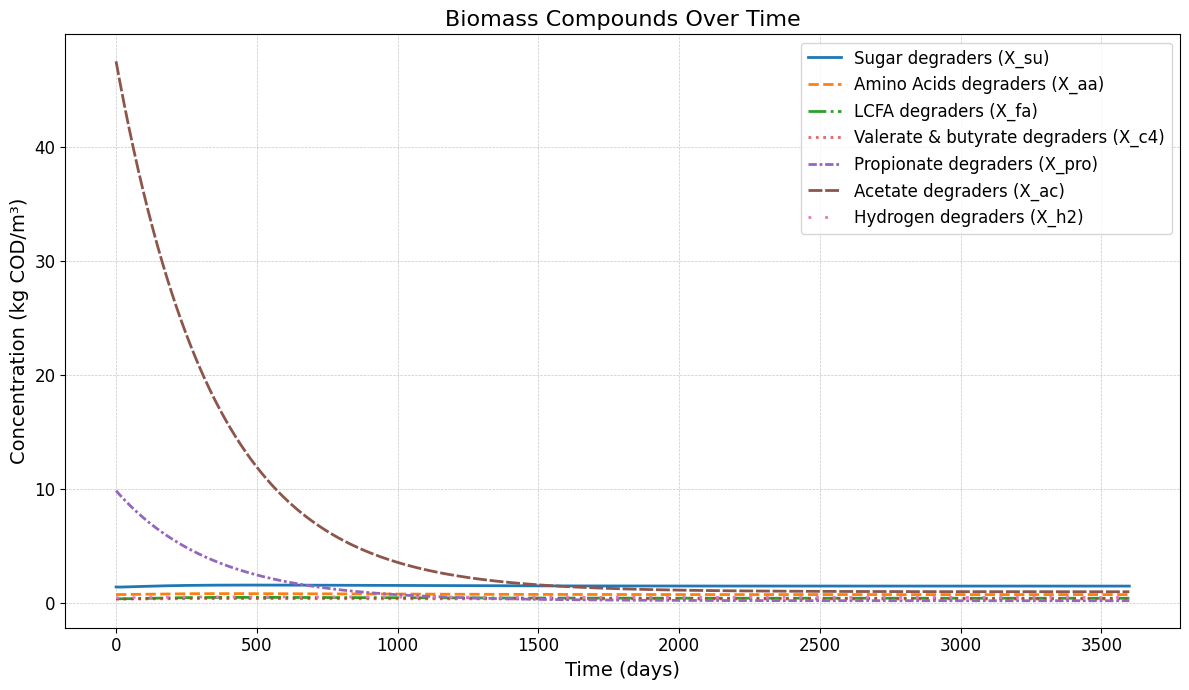

In [34]:
# Plot biomass
plt.figure(figsize=(12, 7))


plt.plot(simulate_results['X_su'],
         label='Sugar degraders (X_su)',
         linestyle='-',            # solid
         linewidth=2)

plt.plot(simulate_results['X_aa'],
         label='Amino Acids degraders (X_aa)',
         linestyle='--',           # dashed
         linewidth=2)

plt.plot(simulate_results['X_fa'],
         label='LCFA degraders (X_fa)',
         linestyle='-.',           # dash-dot
         linewidth=2)

plt.plot(simulate_results['X_c4'],
         label='Valerate & butyrate degraders (X_c4)',
         linestyle=':',            # dotted
         linewidth=2,
         alpha=0.7)

plt.plot(simulate_results['X_pro'],
         label='Propionate degraders (X_pro)',
         linestyle=(0, (3, 1, 1, 1)),  # custom dash sequence
         linewidth=2)

plt.plot(simulate_results['X_ac'],
         label='Acetate degraders (X_ac)',
         linestyle=(0, (5, 1)),       # longer dashes
         linewidth=2)

plt.plot(simulate_results['X_h2'],
         label='Hydrogen degraders (X_h2)',
         linestyle=(0, (1, 5)),       # short dash, long gap
         linewidth=2)

# Title and axis labels
plt.title('Biomass Compounds Over Time', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Concentration (kg COD/m³)', fontsize=14)

# Legend and grid
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show
plt.show()

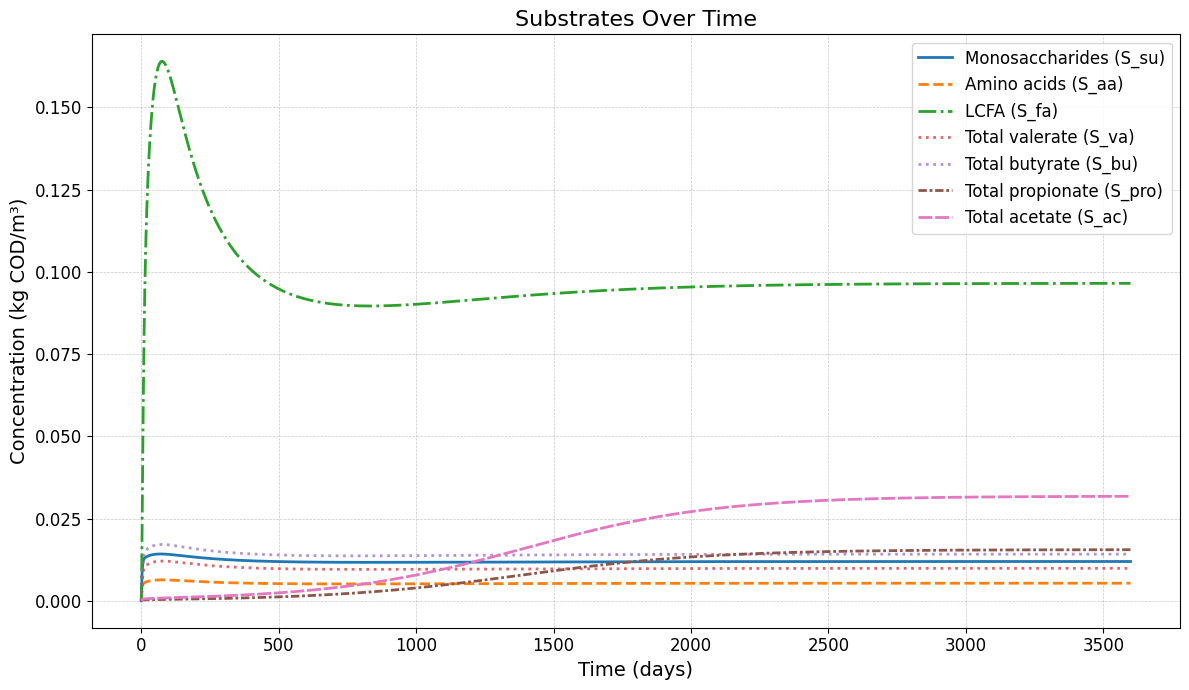

In [35]:
# Plot substrates


plt.figure(figsize=(12, 7))


plt.plot(simulate_results['S_su'],
         label='Monosaccharides (S_su)',
         linestyle='-',            # solid
         linewidth=2)

plt.plot(simulate_results['S_aa'],
         label='Amino acids (S_aa)',
         linestyle='--',           # dashed
         linewidth=2)

plt.plot(simulate_results['S_fa'],
         label='LCFA (S_fa)',
         linestyle='-.',           # dash-dot
         linewidth=2)

plt.plot(simulate_results['S_va'],
         label='Total valerate (S_va)',
         linestyle=':',            # dotted
         linewidth=2,
         alpha=0.7)


plt.plot(simulate_results['S_bu'],
         label='Total butyrate (S_bu)',
         linestyle=':',            # dotted
         linewidth=2,
         alpha=0.7)

plt.plot(simulate_results['S_pro'],
         label='Total propionate (S_pro)',
         linestyle=(0, (3, 1, 1, 1)),  # custom dash sequence
         linewidth=2)

plt.plot(simulate_results['S_ac'],
         label='Total acetate (S_ac)',
         linestyle=(0, (5, 1)),       # longer dashes
         linewidth=2)



# Title and axis labels
plt.title('Substrates Over Time', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Concentration (kg COD/m³)', fontsize=14)

# Legend and grid
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show
plt.show()

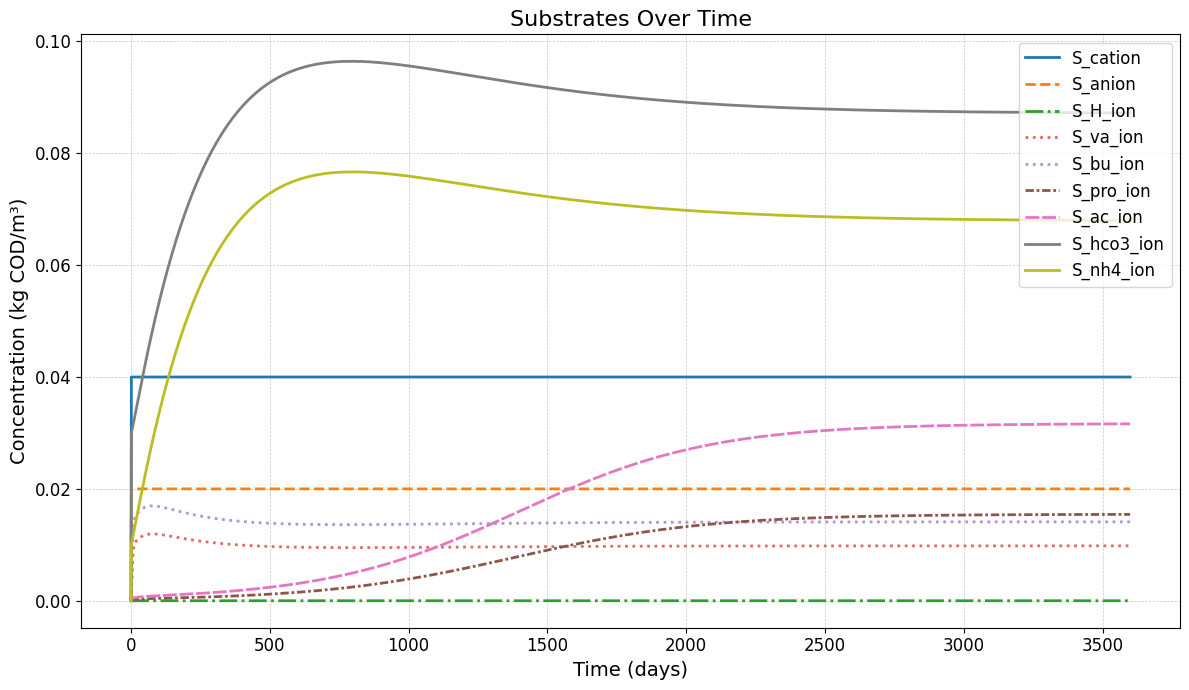

In [36]:
# Plot substrates


plt.figure(figsize=(12, 7))


plt.plot(ions['S_cation'],
         label='S_cation',
         linestyle='-',            # solid
         linewidth=2)

plt.plot(ions['S_anion'],
         label='S_anion',
         linestyle='--',           # dashed
         linewidth=2)

plt.plot(ions['S_H_ion'],
         label='S_H_ion',
         linestyle='-.',           # dash-dot
         linewidth=2)

plt.plot(ions['S_va_ion'],
         label='S_va_ion',
         linestyle=':',            # dotted
         linewidth=2,
         alpha=0.7)


plt.plot(ions['S_bu_ion'],
         label='S_bu_ion',
         linestyle=':',            # dotted
         linewidth=2,
         alpha=0.7)

plt.plot(ions['S_pro_ion'],
         label='S_pro_ion',
         linestyle=(0, (3, 1, 1, 1)),  # custom dash sequence
         linewidth=2)

plt.plot(ions['S_ac_ion'],
         label='S_ac_ion',
         linestyle=(0, (5, 1)),       # longer dashes
         linewidth=2)

plt.plot(ions['S_hco3_ion'],
         label='S_hco3_ion',
  
         linewidth=2)

plt.plot(ions['S_nh4_ion'],
         label='S_nh4_ion',
         linewidth=2)



# Title and axis labels
plt.title('Substrates Over Time', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Concentration (kg COD/m³)', fontsize=14)

# Legend and grid
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show
plt.show()

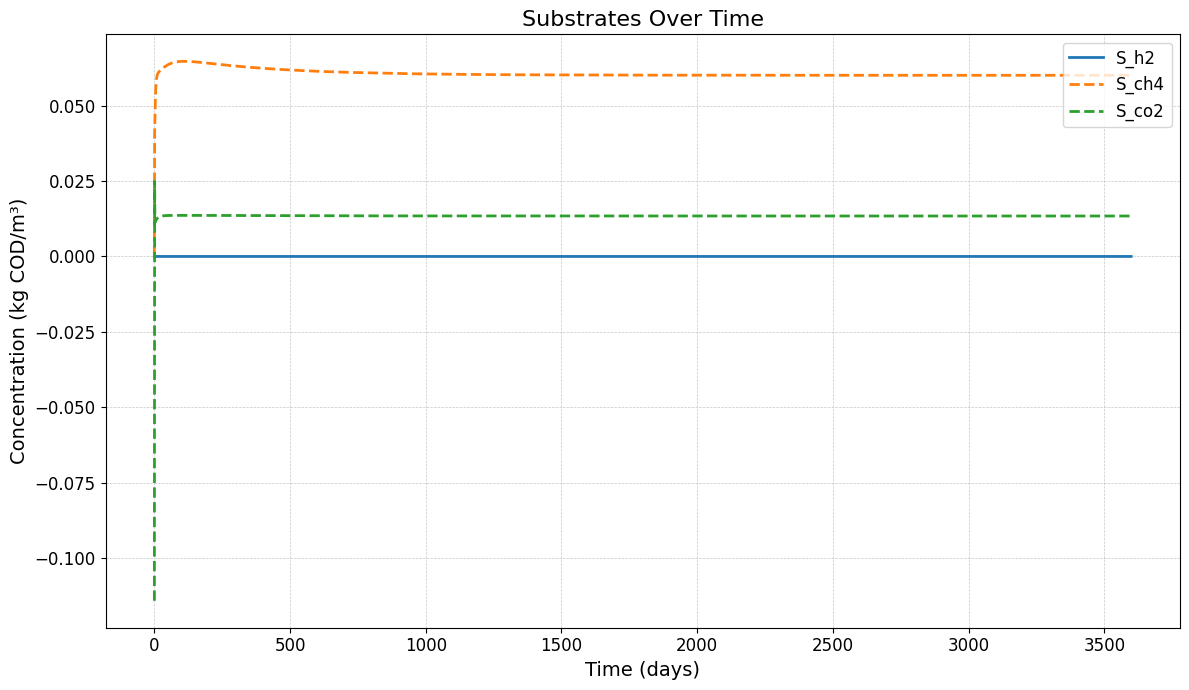

In [37]:
# Plot substrates


plt.figure(figsize=(12, 7))


plt.plot(simulate_results['S_h2'],
         label='S_h2',
         linestyle='-',            # solid
         linewidth=2)

plt.plot(simulate_results['S_ch4'],
         label='S_ch4',
         linestyle='--',           # dashed
         linewidth=2)

plt.plot(simulate_results['S_co2'],
         label='S_co2',
         linestyle='--',           # dashed
         linewidth=2)


# Title and axis labels
plt.title('Substrates Over Time', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Concentration (kg COD/m³)', fontsize=14)

# Legend and grid
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show
plt.show()

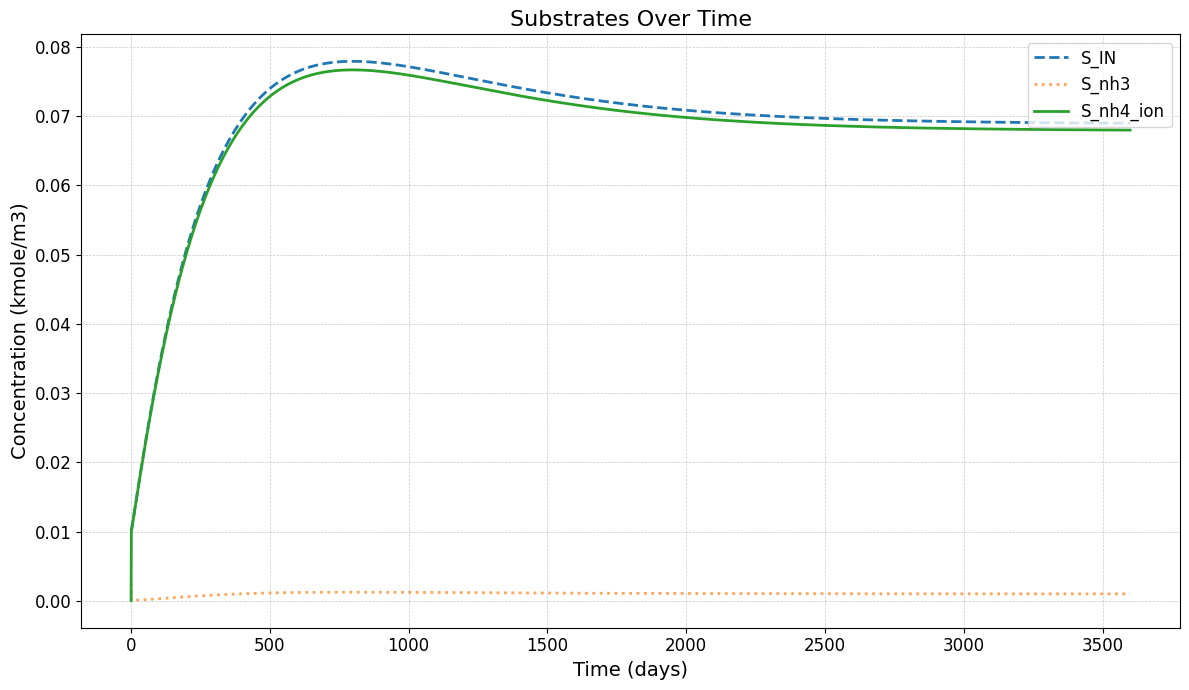

In [38]:
# Plot substrates


plt.figure(figsize=(12, 7))


#plt.plot(simulate_results['S_IC'],
#         label='S_IC',
#         linestyle='-',            # solid
#         linewidth=2)

plt.plot(simulate_results['S_IN'],
         label='S_IN',
         linestyle='--',           # dashed
         linewidth=2)

#plt.plot(simulate_results['S_co2'],
#         label='S_co2',
#         linestyle='-.',           # dash-dot
#         linewidth=2)

plt.plot(simulate_results['S_nh3'],
         label='S_nh3',
         linestyle=':',            # dotted
         linewidth=2,
         alpha=0.7)

plt.plot(ions['S_nh4_ion'],
         label='S_nh4_ion',
         linewidth=2)



# Title and axis labels
plt.title('Substrates Over Time', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Concentration (kmole/m3)', fontsize=14)

# Legend and grid
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show
plt.show()

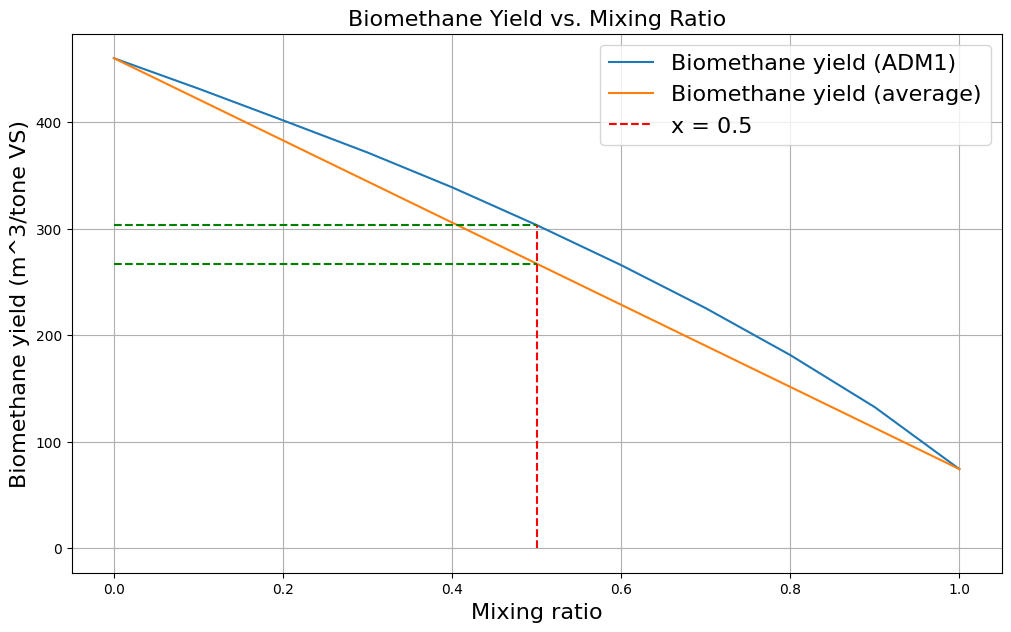

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))


# Data
mixing_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
yield_adm1   = [460, 431.46, 401.69, 371.48, 338.81, 303.37, 265.74, 225.34, 181.32, 132.39, 74.28]
yield_avg    = [460, 421.428, 382.856, 344.284, 305.712, 267.14, 228.568, 189.996, 151.424, 112.852, 74.28]

# Find intersection yields at x = 0.5
y_mid_adm1 = yield_adm1[mixing_ratio.index(0.5)]
y_mid_avg  = yield_avg[mixing_ratio.index(0.5)]

# Plot the two curves
plt.plot(mixing_ratio, yield_adm1, label='Biomethane yield (ADM1)')
plt.plot(mixing_ratio, yield_avg, label='Biomethane yield (average)')

# Vertical dashed at x = 0.5 up to ADM1 curve
plt.plot([0.5, 0.5], [0, y_mid_adm1], linestyle='--',color='red', label='x = 0.5')

# Horizontal dashed at the ADM1 intersection
plt.hlines(y_mid_adm1, mixing_ratio[0], 0.5, color='green', linestyle='--')

# Horizontal dashed at the average intersection
plt.hlines(y_mid_avg, mixing_ratio[0], 0.5, color='green', linestyle='--')

# Labels and legend
plt.xlabel('Mixing ratio', fontsize=16)
plt.ylabel('Biomethane yield (m^3/tone VS)', fontsize=16)
plt.title('Biomethane Yield vs. Mixing Ratio', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)

plt.show()